<a href="https://colab.research.google.com/github/ritzz19/End-to-end-crop-damage-prediction/blob/main/Predict_Crop_Damage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import sqlalchemy

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [8]:
from sqlalchemy import create_engine
address ='crop-database.crsrmxqqzioy.us-east-2.rds.amazonaws.com'
port='5432'
username='swati_admin'
password='******' #Password has been protected
dbname='crop_damage'

postgres_str=('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
             .format(username=username,
                    password=password,
                    ipaddress=address,
                    port=port,
                    dbname=dbname))
cnx=create_engine(postgres_str)

In [9]:
df=pd.read_sql('''SELECT * FROM public.crop_damage_prediction;''',cnx)

In [10]:
df.head()

,id,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [41]:
print(df.shape)

(88858, 11)


In [42]:
df.dtypes

estimated_insects_count      int64
crop_type                    int64
soil_type                    int64
pesticide_use_category       int64
number_doses_week            int64
number_weeks_used          float64
number_weeks_quit            int64
season                       int64
crop_damage                  int64
Avg_Dose_Insect            float64
TotalDoses                 float64
dtype: object

In [43]:
df_original=df

In [44]:
ID_COL, TARGET_COL = 'id', 'crop_damage'

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   estimated_insects_count  88858 non-null  int64  
 1   crop_type                88858 non-null  int64  
 2   soil_type                88858 non-null  int64  
 3   pesticide_use_category   88858 non-null  int64  
 4   number_doses_week        88858 non-null  int64  
 5   number_weeks_used        88858 non-null  float64
 6   number_weeks_quit        88858 non-null  int64  
 7   season                   88858 non-null  int64  
 8   crop_damage              88858 non-null  int64  
 9   Avg_Dose_Insect          88858 non-null  float64
 10  TotalDoses               88858 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 7.5 MB


In [46]:
df.describe()

,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage,Avg_Dose_Insect,TotalDoses
count,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000
mean,1399.012210,0.284375,0.458417,2.264186,25.849952,28.623970,9.589986,1.896959,0.190562,81.888426,761.814633
std,849.048781,0.451119,0.498271,0.461772,15.554428,11.747567,9.900631,0.701322,0.454215,91.534935,574.003013
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000,26.400000,330.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.623970,7.000000,2.000000,0.000000,52.600000,600.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,36.000000,16.000000,2.000000,0.000000,100.800000,1040.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000,819.400000,5510.000000


### Null Values

In [ ]:
null_values_per_variable = 100 * (df.isnull().sum()/df.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

number_weeks_used          10.1
crop_damage                 0.0
season                      0.0
number_weeks_quit           0.0
number_doses_week           0.0
pesticide_use_category      0.0
soil_type                   0.0
crop_type                   0.0
estimated_insects_count     0.0
id                          0.0
dtype: float64

In [47]:
df.crop_damage.value_counts()

0    74238
1    12307
2     2313
Name: crop_damage, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


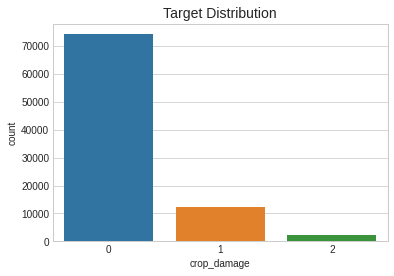

In [48]:
_ = sns.countplot(df[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

## Hypothesis:
### 1. Pesticides are destroying crop more?
### 2. More the number of insects count more damage?
### 3. Crop type and soil type may matter?
### 4. More the number of doses in a week more the damage?

In [49]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]

IndexError: ignored

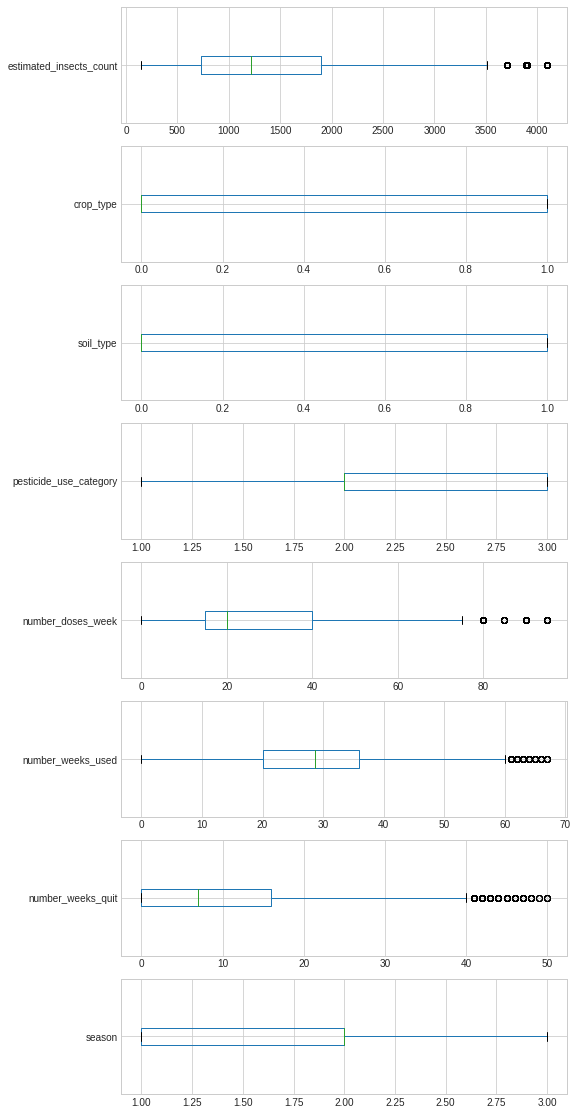

In [50]:
fig, axes = plt.subplots(8, 1, figsize=(8, 20))
for i, c in enumerate(features):
  _ = df[[c]].boxplot(ax=axes[i], vert=False)

### Checking for pesticides

In [54]:
df['pesticide_use_category'].value_counts()

2    63709
3    24312
1      837
Name: pesticide_use_category, dtype: int64

In [55]:
a=df[df['crop_damage']==0]['pesticide_use_category'].value_counts()
b=df[df['crop_damage']==1]['pesticide_use_category'].value_counts()
c=df[df['crop_damage']==2]['pesticide_use_category'].value_counts()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Crop Damage : 2')

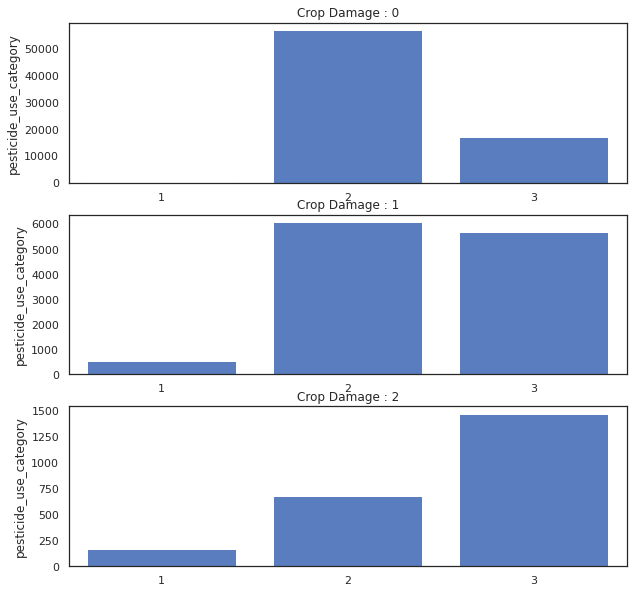

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2')

### 1.It is clear that using type 3 pesticides have given more damage to crop.
### 2.It is observed that type 2 pesticides is not the major reason for crop damage due to pesticides.

## Crop Type

In [57]:
a=df[df['crop_damage']==0]['crop_type'].value_counts()
b=df[df['crop_damage']==1]['crop_type'].value_counts()
c=df[df['crop_damage']==2]['crop_type'].value_counts()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Crop Damage : 2')

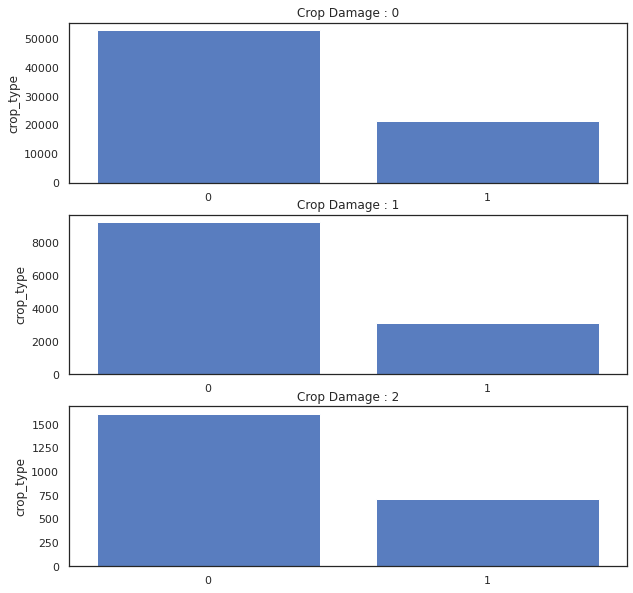

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2')

In [59]:
bins = [0, 500, 1000, 1500, 2000, 2500, 3000,3500,4000,4500]
df['estimated_insects_count_binned'] = pd.cut(df['estimated_insects_count'], bins)

In [60]:
a=df[df['crop_damage']==0]['estimated_insects_count_binned'].value_counts()
b=df[df['crop_damage']==1]['estimated_insects_count_binned'].value_counts()
c=df[df['crop_damage']==2]['estimated_insects_count_binned'].value_counts()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Crop Damage : 2')

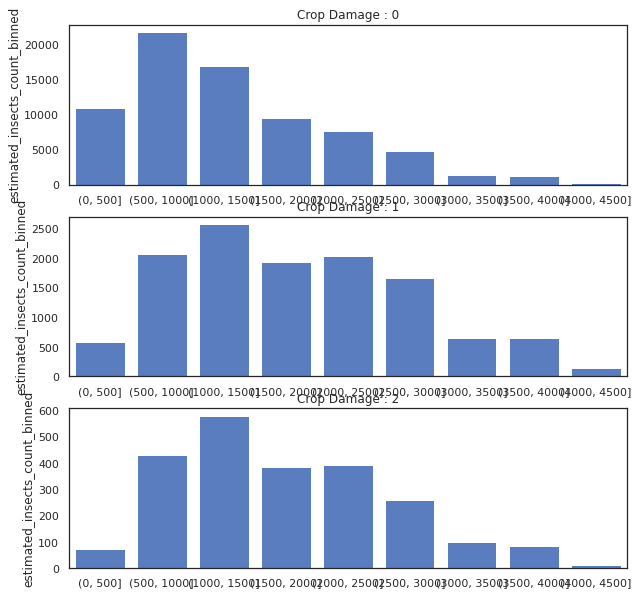

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2')

### We can conclude that it's not high number of insects means more crop damage.

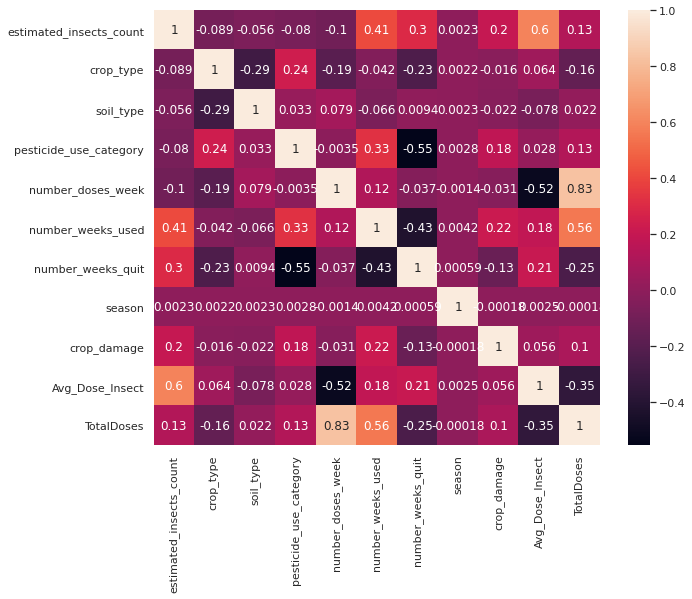

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(),annot=True,ax=ax)

In [63]:
df.head()

,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage,Avg_Dose_Insect,TotalDoses,estimated_insects_count_binned
0,188,1,0,1,0,0.0,0,1,0,0.0,0.0,"(0, 500]"
1,209,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]"
2,257,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]"
3,257,1,1,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]"
4,342,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]"


## Soil Type

In [64]:
a=df[df['crop_damage']==0]['soil_type'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['soil_type'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['soil_type'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Crop Damage : 2')

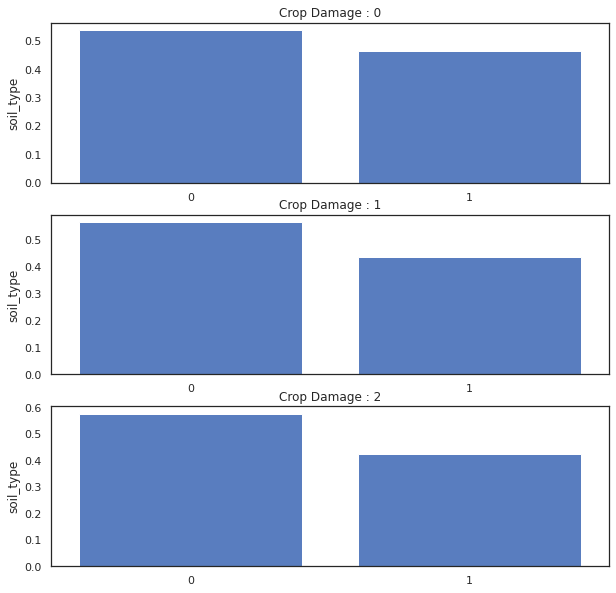

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2')

In [66]:
a=df[df['crop_damage']==0]['number_doses_week'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['number_doses_week'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['number_doses_week'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


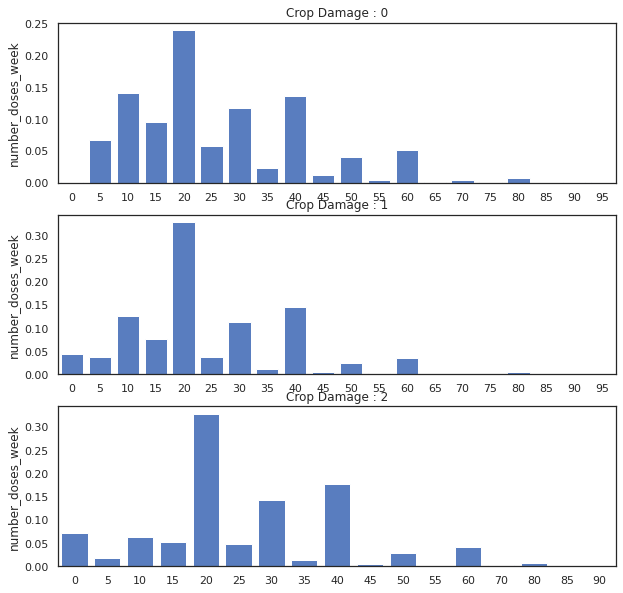

In [67]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2');

### It is observed more number of doses doesn't lead to more crop damage

# Number of weeks used

In [68]:
df.head()

,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage,Avg_Dose_Insect,TotalDoses,estimated_insects_count_binned
0,188,1,0,1,0,0.0,0,1,0,0.0,0.0,"(0, 500]"
1,209,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]"
2,257,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]"
3,257,1,1,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]"
4,342,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]"


In [69]:
df['number_weeks_used'].max()

67.0

In [70]:
bins = [0, 10, 20, 30, 40, 50, 60,70]
df['number_weeks_used_binned'] = pd.cut(df['number_weeks_used'], bins)

In [71]:
a=df[df['crop_damage']==0]['number_weeks_used_binned'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['number_weeks_used_binned'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['number_weeks_used_binned'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


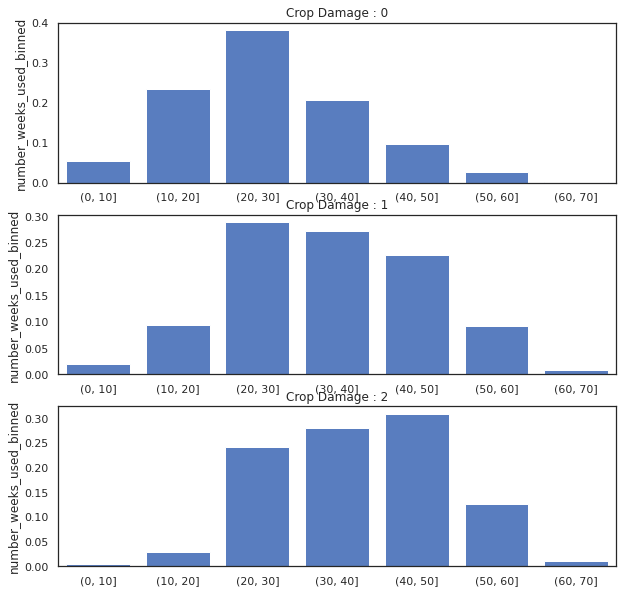

In [72]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2');

## It can be concluded that for higher number of weeks used have more crop damage due to pesticides

# Number of weeks quit

In [73]:
df.head()

,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage,Avg_Dose_Insect,TotalDoses,estimated_insects_count_binned,number_weeks_used_binned
0,188,1,0,1,0,0.0,0,1,0,0.0,0.0,"(0, 500]",NaN
1,209,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]",NaN
2,257,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]",NaN
3,257,1,1,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]",NaN
4,342,1,0,1,0,0.0,0,2,1,0.0,0.0,"(0, 500]",NaN


In [74]:
df['number_weeks_quit'].max()

50

In [75]:
bins = [0, 10, 20, 30, 40, 50, 60]
df['number_weeks_quit_binned'] = pd.cut(df['number_weeks_quit'], bins)

In [76]:
a=df[df['crop_damage']==0]['number_weeks_quit_binned'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['number_weeks_quit_binned'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['number_weeks_quit_binned'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


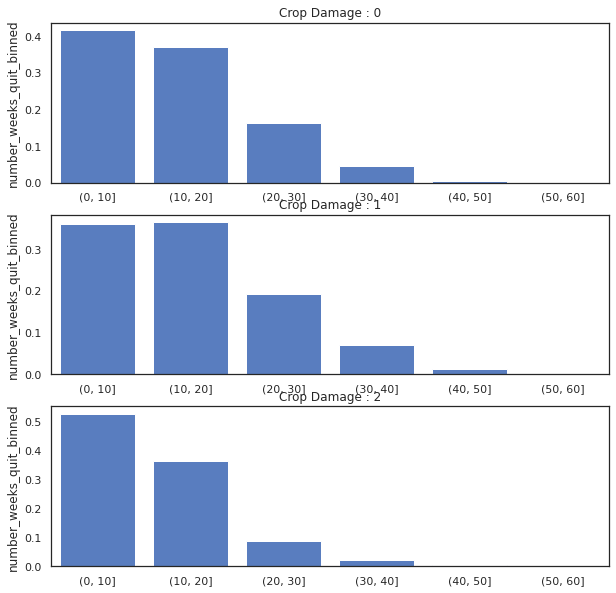

In [77]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2');

# Season

In [78]:
a=df[df['crop_damage']==0]['season'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['season'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['season'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


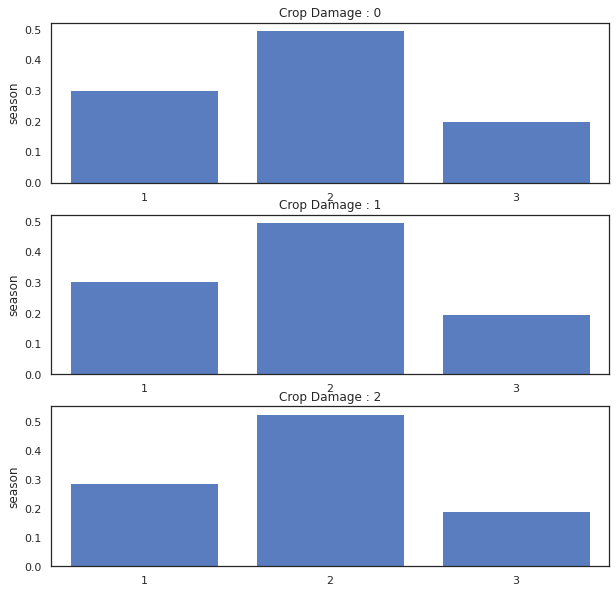

In [79]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2');

In [80]:
df[df['number_doses_week']==0]['pesticide_use_category'].value_counts()

1    837
Name: pesticide_use_category, dtype: int64

In [81]:
df['number_doses_week'].value_counts()

20    22589
40    12298
10    12111
30    10438
15     8178
5      5520
25     4890
60     4367
50     3361
35     1832
45      936
0       837
80      672
70      303
55      277
90       83
65       64
75       61
95       30
85       11
Name: number_doses_week, dtype: int64

In [82]:
df[df['number_weeks_used']==0]['pesticide_use_category'].value_counts()

1    740
Name: pesticide_use_category, dtype: int64

In [83]:
bins = [0, 500, 1000, 1500, 2000, 2500, 3000,3500,4000,4500]
df['estimated_insects_count_binned'] = pd.cut(df['estimated_insects_count'], bins)

In [84]:
a=df[df['pesticide_use_category']==1]['crop_type'].value_counts(normalize=True)
b=df[df['pesticide_use_category']==2]['crop_type'].value_counts(normalize=True)
c=df[df['pesticide_use_category']==3]['crop_type'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


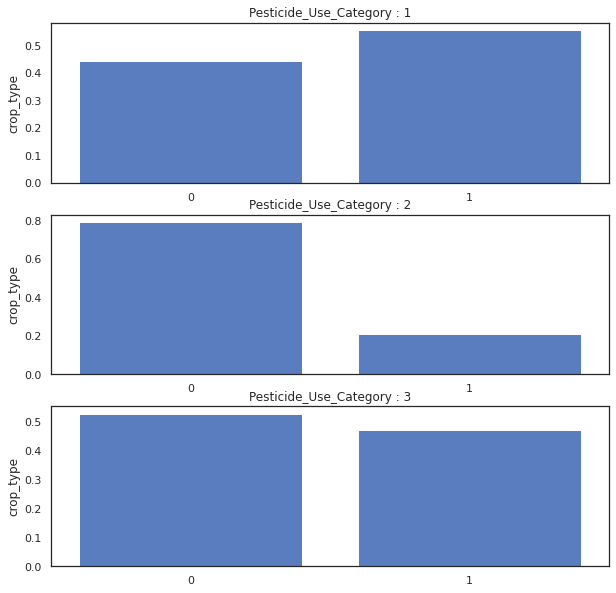

In [85]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Pesticide_Use_Category : 1')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Pesticide_Use_Category : 2')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Pesticide_Use_Category : 3');

### Looks like crop type 1 doesn't use much of pesticides as compare to crop type 0

In [86]:
a=df[df['crop_type']==0]['estimated_insects_count_binned'].value_counts(normalize=True)
b=df[df['crop_type']==1]['estimated_insects_count_binned'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


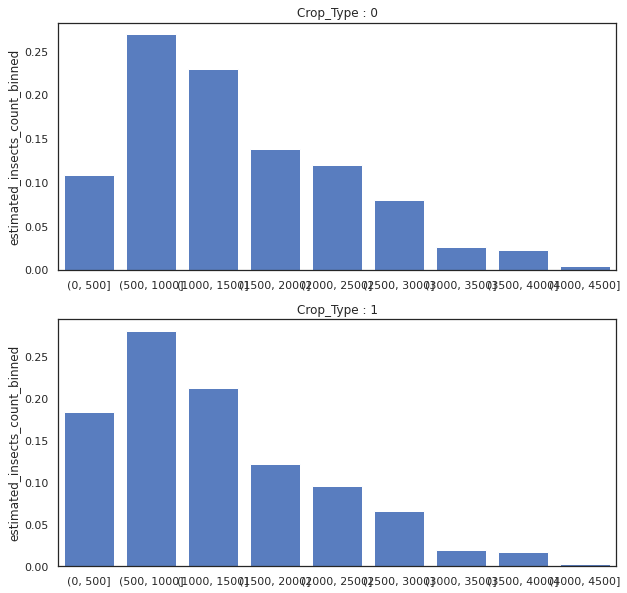

In [87]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop_Type : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop_Type : 1');

### Seems like both type of crops have equal amount of insects

In [88]:
a=df[df['pesticide_use_category']==1]['soil_type'].value_counts(normalize=True)
b=df[df['pesticide_use_category']==2]['soil_type'].value_counts(normalize=True)
c=df[df['pesticide_use_category']==3]['soil_type'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


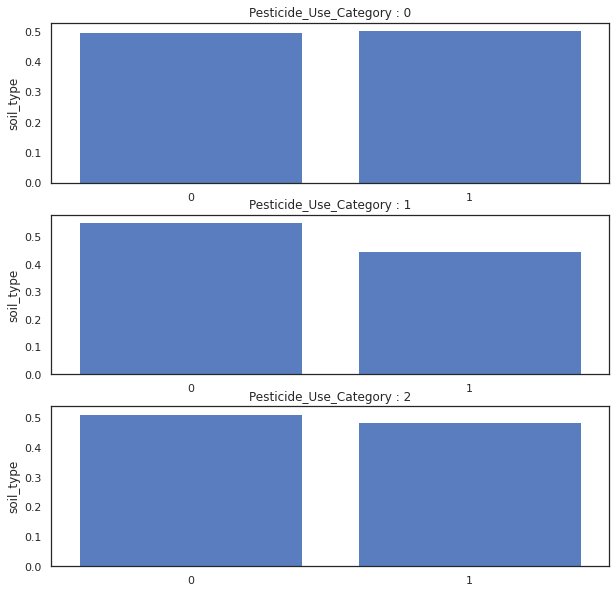

In [89]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Pesticide_Use_Category : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Pesticide_Use_Category : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Pesticide_Use_Category : 2');

### Looks like for soil type 1 pesticides used previously are used as compare to never and current pesticides

# Feature Engineering

In [90]:
df=pd.read_sql('''SELECT * FROM public.crop_damage_prediction;''',cnx)

In [91]:
df.head()

,id,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [92]:
df['Avg_Dose_Insect'] = df['estimated_insects_count']/df['number_doses_week']

In [93]:
df.isnull().sum()

id                            0
estimated_insects_count       0
crop_type                     0
soil_type                     0
pesticide_use_category        0
number_doses_week             0
number_weeks_used          9000
number_weeks_quit             0
season                        0
crop_damage                   0
Avg_Dose_Insect               0
dtype: int64

In [94]:
print("Mean of Number_Weeks_Used before replacement is:",df['number_weeks_used'].mean())
print("Median of Number_Weeks_Used before replacement is:",df['number_weeks_used'].median())

Mean of Number_Weeks_Used before replacement is: 28.62397004683313
Median of Number_Weeks_Used before replacement is: 28.0


In [95]:
df['number_weeks_used'].fillna((df['number_weeks_used'].mean()), inplace=True)
df.isnull().sum().sum()

0

In [96]:
print("Mean of Number_Weeks_Used after replacement is:",df['number_weeks_used'].mean())
print("Median of Number_Weeks_Used after replacement is:",df['number_weeks_used'].median())

Mean of Number_Weeks_Used after replacement is: 28.623970046831996
Median of Number_Weeks_Used after replacement is: 28.62397004683313


In [97]:
df.head()

,id,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage,Avg_Dose_Insect
0,F00000001,188,1,0,1,0,0.0,0,1,0,inf
1,F00000003,209,1,0,1,0,0.0,0,2,1,inf
2,F00000004,257,1,0,1,0,0.0,0,2,1,inf
3,F00000005,257,1,1,1,0,0.0,0,2,1,inf
4,F00000006,342,1,0,1,0,0.0,0,2,1,inf


In [98]:
df['TotalDoses'] = df['number_doses_week'] * df['number_weeks_used']

In [99]:
df.pesticide_use_category.value_counts()

2    63709
3    24312
1      837
Name: pesticide_use_category, dtype: int64

In [100]:
df.head()

,id,estimated_insects_count,crop_type,soil_type,pesticide_use_category,number_doses_week,number_weeks_used,number_weeks_quit,season,crop_damage,Avg_Dose_Insect,TotalDoses
0,F00000001,188,1,0,1,0,0.0,0,1,0,inf,0.0
1,F00000003,209,1,0,1,0,0.0,0,2,1,inf,0.0
2,F00000004,257,1,0,1,0,0.0,0,2,1,inf,0.0
3,F00000005,257,1,1,1,0,0.0,0,2,1,inf,0.0
4,F00000006,342,1,0,1,0,0.0,0,2,1,inf,0.0


In [101]:
df.isnull().sum()

id                         0
estimated_insects_count    0
crop_type                  0
soil_type                  0
pesticide_use_category     0
number_doses_week          0
number_weeks_used          0
number_weeks_quit          0
season                     0
crop_damage                0
Avg_Dose_Insect            0
TotalDoses                 0
dtype: int64

In [102]:
df['Avg_Dose_Insect'].value_counts()

73.900000    856
60.600000    845
inf          837
69.250000    825
83.900000    814
            ... 
12.153846      1
3.212500       1
17.293333      1
2.844444       1
2.900000       1
Name: Avg_Dose_Insect, Length: 1029, dtype: int64

In [103]:
df['Avg_Dose_Insect'].replace(to_replace =np.inf,  
                            value =0,inplace=True)

In [104]:
df.drop(['id'],axis=1,inplace=True)

# Machine Learning Modelling

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [108]:
X=df.loc[:,df.columns != 'crop_damage']
Y=df.crop_damage

In [109]:
skf=StratifiedKFold(n_splits=5,random_state=None)
#skf.get_n_splits(t,val)
for train_index,test_index in skf.split(X,Y):
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=Y.iloc[train_index],Y.iloc[test_index]

In [110]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [111]:
from sklearn.model_selection import train_test_split
X_train_smote, y_train_smote = smote.fit_sample(X_train.astype('float'),y_train)

### Logistic Regression

In [112]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

clf = LogisticRegression()
_ = clf.fit(X_train_smote, y_train_smote)

preds_val1 = clf.predict(X_test)

accuracy_score(y_test,preds_val1)
pd.crosstab(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0.6066625400934106

col_0,0,1,2
crop_damage,,,
0,9843,2220,2784
1,715,635,1112
2,99,60,303


0.4045390273927633
0.5255755867866169


### Decision Tree

In [113]:
clf = DecisionTreeClassifier(random_state = 1)
_ = clf.fit(X_train_smote, y_train_smote)

preds_val1 = clf.predict(X_test)

accuracy_score(y_test,preds_val1)
pd.crosstab(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0.7481852456248945

col_0,0,1,2
crop_damage,,,
0,12563,1908,376
1,1601,694,167
2,266,157,39


0.396389164362769
0.404154813100634


### Random Forest

In [114]:
clf = RandomForestClassifier()
_ = clf.fit(X_train_smote, y_train_smote)

preds_val1 = clf.predict(X_test)

accuracy_score(y_test,preds_val1)
pd.crosstab(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0.8101401159191942

col_0,0,1,2
crop_damage,,,
0,13785,914,148
1,1771,580,111
2,289,141,32


0.4448987433973901
0.4111050986396407


### LGBMClassifier

In [115]:
clf_lgbm = LGBMClassifier(n_estimators = 1000,
                    learning_rate = 0.05,
                    colsample_bytree = 0.76,
                    )
_ = clf_lgbm.fit(X_train_smote, y_train_smote)

preds_val1 = clf_lgbm.predict(X_test)

accuracy_score(y_test,preds_val1)
pd.crosstab(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0.8381632997580327

col_0,0,1,2
crop_damage,,,
0,14389,411,47
1,1876,478,108
2,288,146,28


0.49470320794438805
0.40796972483932525


### CatBoostClassifier

In [ ]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )
_ = clf.fit(X_train_smote, y_train_smote)

preds_val1 = clf.predict(X_test)

accuracy_score(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

# LGBMClassifier gave the best accuracy rate of 83.82%

In [117]:
import pickle
Pkl_Filename = "Pickle_LGBM_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf_lgbm, file)